# Importing Libraries

In [2]:
!pip install torchmetrics

Defaulting to user installation because normal site-packages is not writeable


In [3]:
import torch
from torch.optim import Adam, SGD
from torch import nn, utils
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torchmetrics.classification import Accuracy, Precision, Recall

# Gathering and Organizing the data


The dataset used in the "Neural Networks and Deep Learning" by Michale Nielsen was organized as a zip of tuples
each tuple of length 2 represents: as the first element a 2d ndarray with (784, 1) shape, which represents a flattened (28x28) image,
the second element a nd array with (10, 1) which represents the value (the digit represented) of that image input,
the index where the number 1 is placed is the correct output
Given this context, we are not going to use the dataset given in the book, we've chosen to proceed using the mnist dataset from pytorch datasets.


In [4]:
# Transform PIL image into a tensor. The values are in the range [0, 1]
t = transforms.ToTensor()

# Load datasets for both training and testing.
mnist_training_28 = datasets.MNIST(root='/tmp/mnist', train=True, download=True, transform=t)
mnist_test_28 = datasets.MNIST(root='/tmp/mnist', train=False, download=True, transform=t)

In [5]:
# Transform PIL image into a tensor. The values are in the range [0, 1]
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Load datasets for both training and testing.
mnist_training_224 = datasets.MNIST(root='/tmp/mnist', train=True, download=True, transform=transform)
mnist_test_224 = datasets.MNIST(root='/tmp/mnist', train=False, download=True, transform=transform)

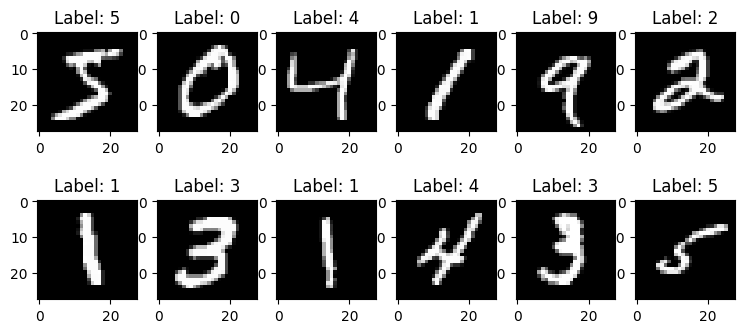

In [6]:
# Checking the dataset

cols = 6
rows = 2

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(1.5*cols, 2*rows))

for i, ax in enumerate(axes.flatten()):
    image, label = mnist_training_28[i]
    ax.set_title(f"Label: {label}")
    ax.imshow(image.squeeze(0), cmap='gray')  # remove first dimension, hence it its a (1, 28, 28) tensor

plt.show()

# Initial CNN - LeNet

LeNet was one of the first architecture of covolutional neural networks, implemented around the 90's. It consisted in 2 convolutional layers, both followed by a average pooling layer, and 3 fully connected layers after those two convolutional.

In [7]:
class LeNet(nn.Module):

  def __init__ (self, num_classes):
    super().__init__()
    self.num_classes = num_classes

    self.net = nn.Sequential(
      nn.LazyConv2d(6, kernel_size=5, padding=2), nn.Sigmoid(),
      nn.AvgPool2d(kernel_size=2, stride=2),
      nn.LazyConv2d(16, kernel_size=5), nn.Sigmoid(),
      nn.AvgPool2d(kernel_size=2, stride=2),
      nn.Flatten(),
      nn.LazyLinear(120), nn.Sigmoid(),
      nn.LazyLinear(84), nn.Sigmoid(),
      nn.LazyLinear(num_classes)
    )

  def forward (self, x):
    return self.net(x)


# LeNet - 2

Implemented the same architechture as LeNetbut added:

- dropout to ensure generalization
- relu to ease training
- maxpooling to extract the features in a more relevant way

In [36]:
class LeNet_2(nn.Module):

  def __init__ (self, num_classes):
    super().__init__()
    self.num_classes = num_classes

    self.net = nn.Sequential(
      nn.LazyConv2d(6, kernel_size=5, padding=2), nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),
      nn.LazyConv2d(16, kernel_size=5), nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),
      nn.Flatten(),
      nn.LazyLinear(120), nn.Sigmoid(),  nn.Dropout(p=0.5),
      nn.LazyLinear(84), nn.Sigmoid(), nn.Dropout(p=0.5),
      nn.LazyLinear(num_classes)
    )

  def forward (self, x):
    return self.net(x)

# Another architecture - AlexNet


AlexNet was an evolution of LeNet, retaining the idea of multiple convolutional layers followed by fully connected layers. With increased computational capacity, AlexNet deepened and broadened the architecture, allowing timely training. It also introduced the relu activation function, which simplified training deep networks by requiring fewer mathematical operations. Additionally, max pooling was used instead of average pooling, leading to better feature comprehension. The incorporation of dropout, a regularization technique, further reduced overfitting by randomly deactivating neurons based on a probability, ensuring a more generalist model.

In [10]:
class AlexNet(nn.Module):

  def __init__ (self, num_classes):
    super().__init__()
    self.num_classes = num_classes

    self.net = nn.Sequential(
      nn.LazyConv2d(96, kernel_size=11, stride=4, padding=1),
      nn.ReLU(), nn.MaxPool2d(kernel_size=3, stride=2),
      nn.LazyConv2d(256, kernel_size=5, padding=2), nn.ReLU(),
      nn.MaxPool2d(kernel_size=3, stride=2),
      nn.LazyConv2d(384, kernel_size=3, padding=1), nn.ReLU(),
      nn.LazyConv2d(384, kernel_size=3, padding=1), nn.ReLU(),
      nn.LazyConv2d(256, kernel_size=3, padding=1), nn.ReLU(),
      nn.MaxPool2d(kernel_size=3, stride=2), nn.Flatten(),
      nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(p=0.5),
      nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(p=0.5),
      nn.LazyLinear(num_classes)
    )

  def forward (self, x):
    return self.net(x)

In [11]:
#tensors shape summarizer function
def layer_summary(net, input_shape):
  X = torch.randn(*input_shape)
  for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape:\t', X.shape)

In [12]:
model = LeNet(10)
layer_summary(model.net, (1, 1, 28, 28))

Conv2d output shape:	 torch.Size([1, 6, 28, 28])
Sigmoid output shape:	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape:	 torch.Size([1, 6, 14, 14])
Conv2d output shape:	 torch.Size([1, 16, 10, 10])
Sigmoid output shape:	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape:	 torch.Size([1, 16, 5, 5])
Flatten output shape:	 torch.Size([1, 400])
Linear output shape:	 torch.Size([1, 120])
Sigmoid output shape:	 torch.Size([1, 120])
Linear output shape:	 torch.Size([1, 84])
Sigmoid output shape:	 torch.Size([1, 84])
Linear output shape:	 torch.Size([1, 10])


/home/heitor/.local/lib/python3.10/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [15]:
model = AlexNet(10)
layer_summary(model.net, (1, 1, 224, 224))

/home/heitor/.local/lib/python3.10/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Conv2d output shape:	 torch.Size([1, 96, 54, 54])
ReLU output shape:	 torch.Size([1, 96, 54, 54])
MaxPool2d output shape:	 torch.Size([1, 96, 26, 26])
Conv2d output shape:	 torch.Size([1, 256, 26, 26])
ReLU output shape:	 torch.Size([1, 256, 26, 26])
MaxPool2d output shape:	 torch.Size([1, 256, 12, 12])
Conv2d output shape:	 torch.Size([1, 384, 12, 12])
ReLU output shape:	 torch.Size([1, 384, 12, 12])
Conv2d output shape:	 torch.Size([1, 384, 12, 12])
ReLU output shape:	 torch.Size([1, 384, 12, 12])
Conv2d output shape:	 torch.Size([1, 256, 12, 12])
ReLU output shape:	 torch.Size([1, 256, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 256, 5, 5])
Flatten output shape:	 torch.Size([1, 6400])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1,

In [37]:
model = LeNet_2(10)
layer_summary(model.net, (1, 1, 28, 28))

Conv2d output shape:	 torch.Size([1, 6, 28, 28])
ReLU output shape:	 torch.Size([1, 6, 28, 28])
MaxPool2d output shape:	 torch.Size([1, 6, 14, 14])
Conv2d output shape:	 torch.Size([1, 16, 10, 10])
ReLU output shape:	 torch.Size([1, 16, 10, 10])
MaxPool2d output shape:	 torch.Size([1, 16, 5, 5])
Flatten output shape:	 torch.Size([1, 400])
Linear output shape:	 torch.Size([1, 120])
Sigmoid output shape:	 torch.Size([1, 120])
Dropout output shape:	 torch.Size([1, 120])
Linear output shape:	 torch.Size([1, 84])
Sigmoid output shape:	 torch.Size([1, 84])
Dropout output shape:	 torch.Size([1, 84])
Linear output shape:	 torch.Size([1, 10])


/home/heitor/.local/lib/python3.10/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


### Preparing - LeNet

In [61]:
#Instance of the model
model_le = LeNet(10)
opt = Adam(model_le.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

# Training with batches of 128 -> lower batch sizes showed many signals of overfitting
batch_size = 128
train_loader = utils.data.DataLoader(mnist_training_28, batch_size=batch_size, shuffle=True)

### Training - LeNet

In [62]:
losses_le = []

for epoch in range(10): # Number of Epochs
  for imgs, labels in train_loader:
    predictions = model_le(imgs)
    loss = loss_fn(predictions, labels)

    # Backprop
    opt.zero_grad()
    loss.backward()
    opt.step()

    losses_le.append(float(loss))
  print(f"Epoch {epoch}: Loss = {float(loss)}")

Epoch 0: Loss = 0.6058849692344666
Epoch 1: Loss = 0.2540152072906494
Epoch 2: Loss = 0.18828441202640533
Epoch 3: Loss = 0.18815547227859497
Epoch 4: Loss = 0.1786431521177292
Epoch 5: Loss = 0.09331715852022171
Epoch 6: Loss = 0.1309857815504074
Epoch 7: Loss = 0.013749360106885433
Epoch 8: Loss = 0.11614000797271729
Epoch 9: Loss = 0.048419248312711716


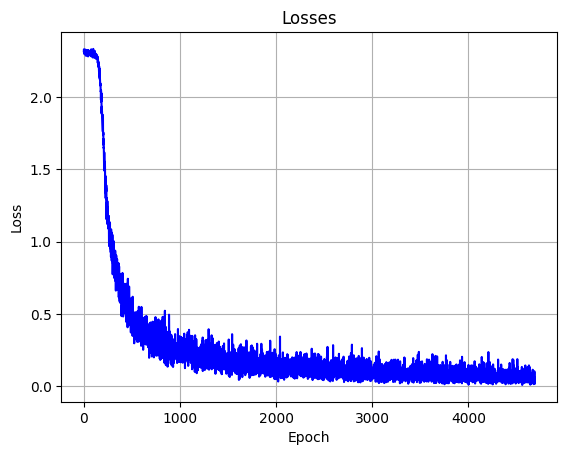

In [63]:
#Plot losses
plt.plot(losses_le, linestyle='-', color='blue')
plt.title('Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

### Accuracy

In [71]:
batch_size_test = 10000
test_loader = utils.data.DataLoader(mnist_test_28, batch_size=batch_size_test)

# Image tensor has shape (10000, 1, 28, 28)
imgs, labels = next(iter(test_loader))

# Calculates the results for all the images, returning us a tensor of shape (10000, 10)
# imgs[i][j] => i -> image; j -> the score for that number [0-1]
predictions = model_le(imgs)

# For each row determine the columns with the highest score, the prediction
predicted_classes = torch.argmax(predictions, dim=1)

#Calculate the multiclass accuracy
class_accuracy_metric = Accuracy(task='multiclass', num_classes=10, average=None)
class_accuracy_metric(predicted_classes, labels)
class_accuracy = class_accuracy_metric.compute()

# Calculate the total accuracy
total_accuracy = (predicted_classes == labels).float().mean().item()

print(f"Total Accuracy: {total_accuracy:.4f}")

Total Accuracy: 0.9772


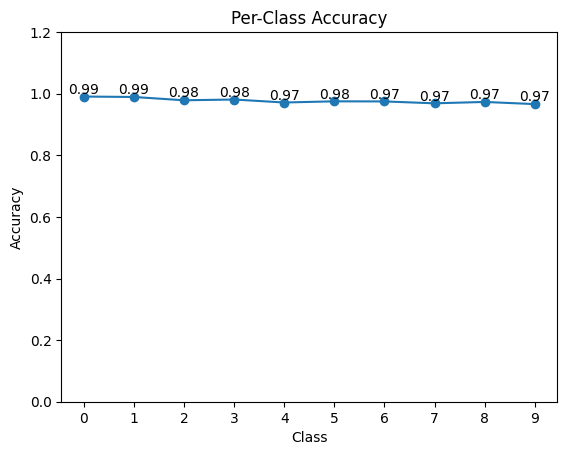

In [65]:
# Plotting the per-class accuracy
class_indices = range(10)

plt.plot(class_indices, class_accuracy, marker='o')
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.title('Per-Class Accuracy')
plt.ylim(0, 1.2)
plt.xticks(class_indices)

# Add labels to each marker
for x, y in zip(class_indices, class_accuracy):
    plt.text(x, y, f'{y:.2f}', ha='center', va='bottom')

plt.show()

### Precision
Measures the accuracy of the positive predictions made by the model.

It can be described as: true positives / (true positives + false positives)

In [66]:
# Calculating the precision for each class
class_precision_metric = Precision(task='multiclass', num_classes=10, average=None)
class_precision_metric(predicted_classes, labels)
class_precision = class_precision_metric.compute()

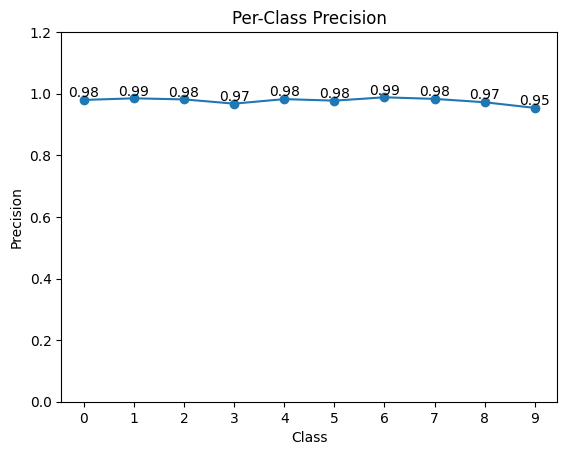

In [67]:
# Plotting the per-class precision
class_indices = range(10)

plt.plot(class_indices, class_precision, marker='o')
plt.xlabel('Class')
plt.ylabel('Precision')
plt.title('Per-Class Precision')
plt.ylim(0, 1.2)
plt.xticks(class_indices)

# Add labels to each marker
for x, y in zip(class_indices, class_precision):
    plt.text(x, y, f'{y:.2f}', ha='center', va='bottom')

plt.show()

### Recall
Measures the ability of the model to predict positive samples correctly

It can be described as: true positives / (true positives + false negatives)

In [68]:
# Calculating the recall for each class
class_recall_metric = Recall(task='multiclass', num_classes=10, average=None)
class_recall_metric(predicted_classes, labels)
class_recall = class_recall_metric.compute()

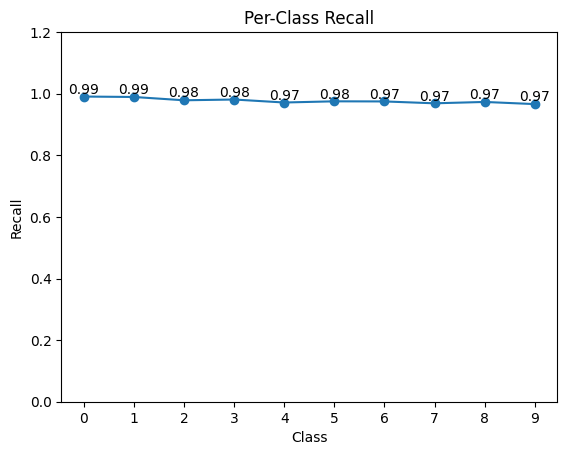

In [69]:
# Plotting the recall
class_indices = range(10)

plt.plot(class_indices, class_recall, marker='o')
plt.xlabel('Class')
plt.ylabel('Recall')
plt.title('Per-Class Recall')
plt.ylim(0, 1.2)
plt.xticks(class_indices)

# Add labels to each marker
for x, y in zip(class_indices, class_recall):
    plt.text(x, y, f'{y:.2f}', ha='center', va='bottom')

plt.show()

### Preparing - LeNet 2

In [72]:
#Instance of the model
model_le_2 = LeNet_2(10)
opt_2 = Adam(model_le_2.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

# Training with batches of 128 -> lower batch sizes showed many signals of overfitting
batch_size = 128
train_loader_2 = utils.data.DataLoader(mnist_training_28, batch_size=batch_size, shuffle=True)

### Training - LeNet 2

In [73]:
losses_le_2 = []

for epoch in range(10): # Number of Epochs
  for imgs, labels in train_loader_2:
    predictions = model_le_2(imgs)
    loss = loss_fn(predictions, labels)

    # Backprop
    opt_2.zero_grad()
    loss.backward()
    opt_2.step()

    losses_le_2.append(float(loss))
  print(f"Epoch {epoch}: Loss = {float(loss)}")

Epoch 0: Loss = 0.37859800457954407
Epoch 1: Loss = 0.08591625094413757
Epoch 2: Loss = 0.08068173378705978
Epoch 3: Loss = 0.20922498404979706
Epoch 4: Loss = 0.16494165360927582
Epoch 5: Loss = 0.05823230370879173
Epoch 6: Loss = 0.034323062747716904
Epoch 7: Loss = 0.04410126432776451
Epoch 8: Loss = 0.03628695011138916
Epoch 9: Loss = 0.08687210083007812


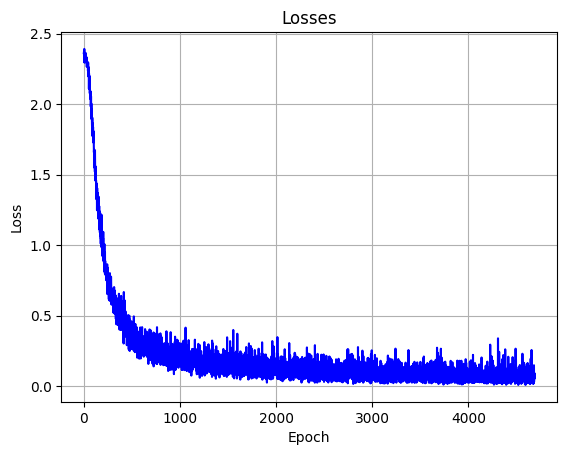

In [74]:
#Plot losses
plt.plot(losses_le_2, linestyle='-', color='blue')
plt.title('Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

### Accuracy

In [75]:
batch_size_test = 10000
test_loader = utils.data.DataLoader(mnist_test_28, batch_size=batch_size_test)

# Image tensor has shape (10000, 1, 28, 28)
imgs, labels = next(iter(test_loader))

# Calculates the results for all the images, returning us a tensor of shape (10000, 10)
# imgs[i][j] => i -> image; j -> the score for that number [0-1]
predictions = model_le_2(imgs)

# For each row determine the columns with the highest score, the prediction
predicted_classes = torch.argmax(predictions, dim=1)

#Calculate the multiclass accuracy
class_accuracy_metric = Accuracy(task='multiclass', num_classes=10, average=None)
class_accuracy_metric(predicted_classes, labels)
class_accuracy = class_accuracy_metric.compute()

# Calculate the total accuracy
total_accuracy = (predicted_classes == labels).float().mean().item()

print(f"Total Accuracy: {total_accuracy:.4f}")

Total Accuracy: 0.9799


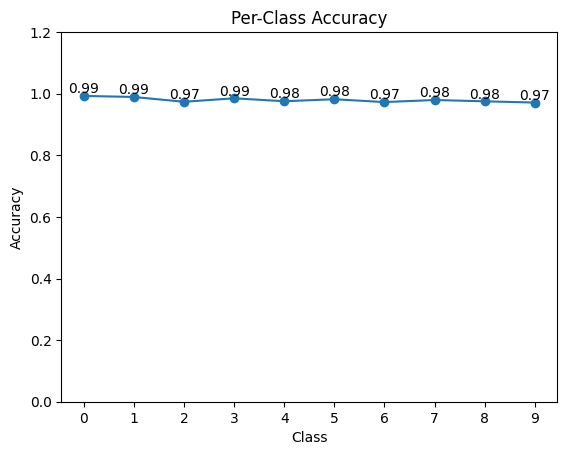

In [76]:
# Plotting the per-class accuracy
class_indices = range(10)

plt.plot(class_indices, class_accuracy, marker='o')
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.title('Per-Class Accuracy')
plt.ylim(0, 1.2)
plt.xticks(class_indices)

# Add labels to each marker
for x, y in zip(class_indices, class_accuracy):
    plt.text(x, y, f'{y:.2f}', ha='center', va='bottom')

plt.show()

### Precision

In [77]:
# Calculating the precision for each class
class_precision_metric = Precision(task='multiclass', num_classes=10, average=None)
class_precision_metric(predicted_classes, labels)
class_precision = class_precision_metric.compute()

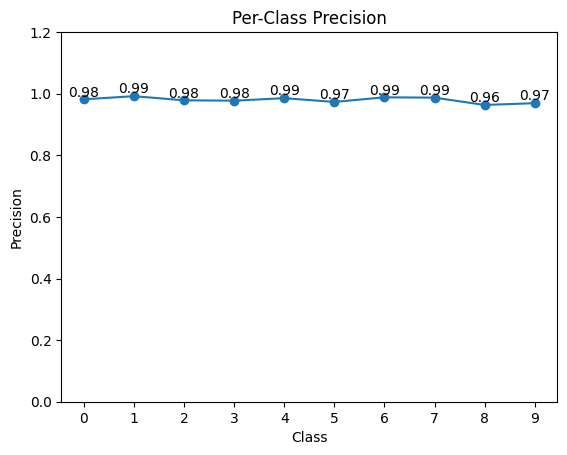

In [78]:
# Plotting the per-class precision
class_indices = range(10)

plt.plot(class_indices, class_precision, marker='o')
plt.xlabel('Class')
plt.ylabel('Precision')
plt.title('Per-Class Precision')
plt.ylim(0, 1.2)
plt.xticks(class_indices)

# Add labels to each marker
for x, y in zip(class_indices, class_precision):
    plt.text(x, y, f'{y:.2f}', ha='center', va='bottom')

plt.show()

### Recall


In [79]:
# Calculating the recall for each class
class_recall_metric = Recall(task='multiclass', num_classes=10, average=None)
class_recall_metric(predicted_classes, labels)
class_recall = class_recall_metric.compute()

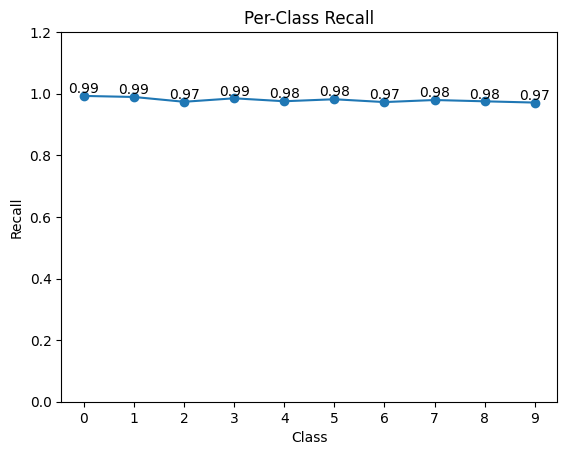

In [80]:
# Plotting the recall
class_indices = range(10)

plt.plot(class_indices, class_recall, marker='o')
plt.xlabel('Class')
plt.ylabel('Recall')
plt.title('Per-Class Recall')
plt.ylim(0, 1.2)
plt.xticks(class_indices)

# Add labels to each marker
for x, y in zip(class_indices, class_recall):
    plt.text(x, y, f'{y:.2f}', ha='center', va='bottom')

plt.show()

### Preparing - AlexNet

In [85]:
#Instance of the model
model_alex = AlexNet(10);
opt_alex = Adam(model_alex.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

# Training with batches of 128 -> lower batch sizes showed many signals of overfitting
batch_size = 128
train_loader_alex = utils.data.DataLoader(mnist_training_224, batch_size=batch_size, shuffle=True)

### Training - AlexNet

It takes too long to train this network, too much computation and its not worth it

In [86]:
losses_al = []

for epoch in range(10): # Number of Epochs
  for imgs, labels in train_loader_alex:
    predictions = model_alex(imgs)
    loss = loss_fn(predictions, labels)

    # Backprop
    opt_alex.zero_grad()
    loss.backward()
    opt_alex.step()

    losses_al.append(float(loss))
  print(f"Epoch {epoch}: Loss = {float(loss)}")

Epoch 0: Loss = 0.11875855177640915
Epoch 1: Loss = 0.03085704706609249
Epoch 2: Loss = 0.031593240797519684
Epoch 3: Loss = 0.21619753539562225
Epoch 4: Loss = 0.09956339746713638
Epoch 5: Loss = 0.031057192012667656
Epoch 6: Loss = 0.010717448778450489
Epoch 7: Loss = 0.03703451529145241
Epoch 8: Loss = 0.08012419193983078
Epoch 9: Loss = 0.09870507568120956


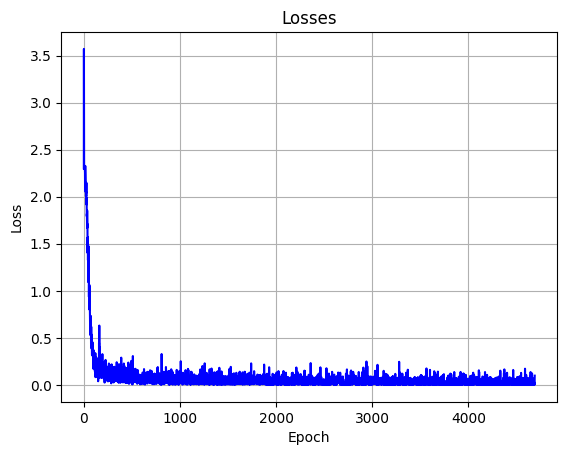

In [87]:
#Plot losses
plt.plot(losses_al, linestyle='-', color='blue')
plt.title('Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

### Accuracy

In [ ]:
print('a')

In [88]:
batch_size_test = 1000
test_loader_alex = utils.data.DataLoader(mnist_test_224, batch_size=batch_size_test)

# Image tensor has shape (10000, 1, 28, 28)
imgs, labels = next(iter(test_loader_alex))

# Calculates the results for all the images, returning us a tensor of shape (10000, 10)
# imgs[i][j] => i -> image; j -> the score for that number [0-1]
predictions = model_alex(imgs)

# For each row determine the columns with the highest score, the prediction
predicted_classes = torch.argmax(predictions, dim=1)

#Calculate the multiclass accuracy
class_accuracy_metric = Accuracy(task='multiclass', num_classes=10, average=None)
class_accuracy_metric(predicted_classes, labels)
class_accuracy = class_accuracy_metric.compute()

# Calculate the total accuracy
total_accuracy = (predicted_classes == labels).float().mean().item()

print(f"Total Accuracy: {total_accuracy:.4f}")

: 

: 

In [ ]:
# Plotting the per-class accuracy
class_indices = range(10)

plt.plot(class_indices, class_accuracy, marker='o')
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.title('Per-Class Accuracy')
plt.ylim(0, 1.2)
plt.xticks(class_indices)

# Add labels to each marker
for x, y in zip(class_indices, class_accuracy):
    plt.text(x, y, f'{y:.2f}', ha='center', va='bottom')

plt.show()

### Precision
Measures the accuracy of the positive predictions made by the model.

It can be described as: true positives / (true positives + false positives)

In [ ]:
# Calculating the precision for each class
class_precision_metric = Precision(task='multiclass', num_classes=10, average=None)
class_precision_metric(predicted_classes, labels)
class_precision = class_precision_metric.compute()

In [ ]:
# Plotting the per-class precision
class_indices = range(10)

plt.plot(class_indices, class_precision, marker='o')
plt.xlabel('Class')
plt.ylabel('Precision')
plt.title('Per-Class Precision')
plt.ylim(0, 1.2)
plt.xticks(class_indices)

# Add labels to each marker
for x, y in zip(class_indices, class_precision):
    plt.text(x, y, f'{y:.2f}', ha='center', va='bottom')

plt.show()

### Recall
Measures the ability of the model to predict positive samples correctly

It can be described as: true positives / (true positives + false negatives)

In [ ]:
# Calculating the recall for each class
class_recall_metric = Recall(task='multiclass', num_classes=10, average=None)
class_recall_metric(predicted_classes, labels)
class_recall = class_recall_metric.compute()

In [ ]:
# Plotting the recall
class_indices = range(10)

plt.plot(class_indices, class_recall, marker='o')
plt.xlabel('Class')
plt.ylabel('Recall')
plt.title('Per-Class Recall')
plt.ylim(0, 1.2)
plt.xticks(class_indices)

# Add labels to each marker
for x, y in zip(class_indices, class_recall):
    plt.text(x, y, f'{y:.2f}', ha='center', va='bottom')

plt.show()

# References

This notebook is based on the books:

"Dive into deep learning" by Aston Zhang, Zack C. Lipton, Mu Li and Alex J. Smola.

"Neural Networks and Deep Learning" by Michael Nielsen.